In [5]:
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/avic/OOD_Orientation_Generalization/")
from tools import *

In [6]:
current_cmap = plt.cm.get_cmap()
current_cmap.set_bad(color='gray')

def show(arr, remove_axes=True, vmin=0, vmax=1):
    plt.close('all')
    fig = plt.imshow(arr, vmin=vmin, vmax=vmax)
    if remove_axes:
        plt.axis('off')

In [21]:
def compute_cubelet(frame):
    return np.mean(frame.correct), len(frame)

def generate_prediction_heatmap(exp_num, data_div, num_cubelets=20):
    dim0s, dim1s, dim2s = get_heatmap_cell_ranges(num_cubelets, num_cubelets)
    
    d = pd.read_csv(f'/home/avic/OOD_Orientation_Generalization/demo/exps/exp{exp_num}/Div{data_div}.gzip', compression='gzip')
    
    heatmap = np.empty(num_cubelets ** 3)
    heatmap[:] = np.nan
    
    groups = d.groupby([pd.cut(d.object_x, dim0s), pd.cut(d.object_y, dim1s), pd.cut(d.object_z, dim2s)])
    groups_count = groups.ngroups
    
    for i, group in tqdm.tqdm(enumerate(groups), total=groups_count, position=0, leave=True):
        heatmap[i], _ = compute_cubelet(group[1])
    
    heatmap = heatmap.reshape((num_cubelets, num_cubelets, num_cubelets))
    
    heatmap = np.moveaxis(heatmap, 2, 0)
    
    return heatmap

In [22]:
b = generate_prediction_heatmap(0, 40)

100%|██████████| 7977/7977 [00:02<00:00, 3514.74it/s]


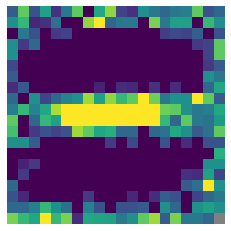

In [23]:
show(b[0])

In [ ]:
dim0s, dim1s, dim2s = get_heatmap_cell_ranges(20, 20)

In [ ]:
def get_midpoints(dim):
    return dim[:-1] + ((dim[1:] - dim[:-1]) / 2)

In [ ]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [ ]:
a = cartesian_product(get_midpoints(dim0s), get_midpoints(dim1s), get_midpoints(dim2s))

In [ ]:
bin_rotations = np.array([[0,0],[-0.2,-0.2],[-0.2,0.2],[0.2,-0.2],[0.2,0.2]])

In [ ]:
def twod_alignment(v1, v2):
    r1 = R.from_euler('zyx', v1[:, -1::-1])
    r2 = R.from_euler('zyx', v2[-1::-1])

    r3 = r2*r1.inv()
    a = r3.as_matrix()

    
    val, v = np.linalg.eig(a)
    idx = np.argwhere(np.round(val, 6) == 1)
    ax = v[idx[:,0], :, idx[:,1]]
    
    return np.abs(np.pi-np.arccos(np.round((a.trace(axis1=1, axis2=2) - 1) / 2, 6)))/np.pi, np.abs(ax[...,1])

In [ ]:
heatmap = np.zeros(20 ** 3)
for i, ai in tqdm.tqdm(enumerate(a)):
    heatmap[i], _ = np.max(twod_alignment(bin_rotations, ai), axis=1)

In [ ]:
heatmap = heatmap.reshape(20, 20, 20)

In [ ]:
bin_rotations

In [ ]:
br = np.repeat(np.insert(bin_rotations, 2, None, axis=1), len(dim2s), axis=0).reshape(len(bin_rotations), len(dim2s), 3)
br[:,:,2] = dim2s
bin_rotations = br.reshape(-1,3)

In [ ]:
br